##### This script presents the model building, training and deployment of AE-PNet
##### It was developed using Python 3.10.6 Tensorflow 2.10.0 Keras: 2.10.0
##### It was tested on Nov. 19,2024
##### In this example, we trained the model using 1500 manually picked waveforms as training and validation data
##### by Tianyang GUO @ Tiziana Vanorio lab, Stanford, 2024
##### guoty@stanford.edu; guoty962464@gmail.com

# Import libaraies

In [1]:
from platform import python_version

import numpy as np
import pandas as pd
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, BatchNormalization, ReLU, Dense, Flatten, Dropout, MaxPool1D, Lambda, MaxPool2D
from keras.layers.convolutional import Conv1D, Conv1DTranspose, Conv2D, Conv2DTranspose

import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
import os

# Building and training AE-PNet

In [2]:
print('Python:', python_version(), '\nTensorflow:', tf.__version__, '\nKeras:', keras.__version__)

Python: 3.10.6 
Tensorflow: 2.10.0 
Keras: 2.10.0


In [3]:
# Set random seed
ranseed = 99
np.random.seed(ranseed)
tf.random.set_seed(ranseed)

In [4]:
# utility for skip connections
def crop_concat(net1, net2):
    """
    the size(net1) <= size(net2)
    """
    # Number of channels
    chn1 = net1.get_shape().as_list()[-1]
    chn2 = net2.get_shape().as_list()[-1]
    # Shapes
    net1_shape = tf.shape(net1)
    net2_shape = tf.shape(net2)
    # Offset for crop (0 for batch and channel)
    offsets = [0, (net2_shape[1] - net1_shape[1]) // 2, 0]
    # Size of crop 
    size = [-1, net1_shape[1], -1]
    # Crop
    net2_resize = tf.slice(net2, offsets, size)
    # Concatenate
    out = tf.concat([net1, net2_resize], 2)
    out = tf.ensure_shape(out, [None, None, chn1 + chn2])
    return out 

In [9]:
# model architecture - modified from PASENET (with 1 less hidden layer)
def create_AEPNET():
    # parameters
    k_size = 3 
    k_num1 = 8
    k_num2 = 11
    k_num3 = 16
    k_num4 = 22

    n_kernels = [k_num1, 
                 k_num1, k_num1, 
                 k_num2, k_num2, 
                 k_num3, k_num3, 
                 k_num4, 
                 k_num3, k_num3, 
                 k_num2, k_num2, 
                 k_num1, k_num1]
    n_pick = 1 # just P-wave arrival
    n_class = 2 #Two 'classes' P-wave arrival
    s_size = 4
    pad = 'same'
    n_pts = 551

    # input layer
    visible = Input(shape=(n_pts, 1), name='Input')

    # downward

    # hidden layer 1
    conv1 = Conv1D(n_kernels[0], kernel_size=k_size, padding=pad, name='Conv10')(visible)#(visible)
    bn11 = BatchNormalization(name='BatchNorm11')(conv1)
    r11 = ReLU()(bn11)
    conv11 = Conv1D(n_kernels[1], kernel_size=k_size, padding=pad, name='Conv11')(r11)
    bn12 = BatchNormalization(name='BatchNorm12')(conv11)
    r12 = ReLU()(bn12)

    # hidden layer 2
    convs2 = Conv1D(n_kernels[2], kernel_size=k_size, strides=s_size, padding=pad, name='Convs20')(r12)
    bn21 = BatchNormalization(name='BatchNorm21')(convs2)
    r21 = ReLU()(bn21)
    conv21 = Conv1D(n_kernels[3], kernel_size=k_size, padding=pad, name='Conv21')(r21)
    bn22 = BatchNormalization(name='BatchNorm22')(conv21)
    r22 = ReLU()(bn22)

    # hidden layer 3
    convs3 = Conv1D(n_kernels[4], kernel_size=k_size, strides=s_size, padding=pad, name='Convs30')(r22)
    bn31 = BatchNormalization(name='BatchNorm31')(convs3)
    r31 = ReLU()(bn31)
    conv31 = Conv1D(n_kernels[5], kernel_size=k_size, padding=pad, name='Conv31')(r31)
    bn32 = BatchNormalization(name='BatchNorm32')(conv31)
    r32 = ReLU()(bn32)

    # hidden layer 4
    convs4 = Conv1D(n_kernels[6], kernel_size=k_size, strides=s_size, padding=pad, name='Convs40')(r32)
    bn41 = BatchNormalization(name='BatchNorm41')(convs4)
    r41 = ReLU()(bn41)
    conv41 = Conv1D(n_kernels[7], kernel_size=k_size, padding=pad, name='Conv41')(r41)
    bn42 = BatchNormalization(name='BatchNorm42')(conv41)
    r42 = ReLU()(bn42)


    # upward

    # hidden layer 3 with skip connection
    convsT3 = Conv1DTranspose(n_kernels[8], kernel_size=k_size, strides=s_size, padding=pad, name='ConvsT30')(r42)
    bn33 = BatchNormalization(name='BatchNorm33')(convsT3)
    r33 = ReLU()(bn33)
    skip3 = crop_concat(bn32, r33)
    conv32 = Conv1D(n_kernels[9], kernel_size=k_size, padding=pad, name='Conv32')(skip3)
    bn34 = BatchNormalization(name='BatchNorm34')(conv32)
    r34 = ReLU()(bn34)

    # hidden layer 2
    convsT2 = Conv1DTranspose(n_kernels[10], kernel_size=k_size, strides=s_size, padding=pad, name='ConvsT20')(r34)
    bn23 = BatchNormalization(name='BatchNorm23')(convsT2)
    r23 = ReLU()(bn23)
    skip2 = crop_concat(bn22, r23)
    conv22 = Conv1D(n_kernels[11], kernel_size=k_size, padding=pad, name='Conv22')(skip2)
    bn24 = BatchNormalization(name='BatchNorm24')(conv22)
    r24 = ReLU()(bn24)

    # hidden layer 1
    convsT1 = Conv1DTranspose(n_kernels[12], kernel_size=k_size, strides=s_size, padding=pad, name='ConvsT10')(r24)
    bn13 = BatchNormalization(name='BatchNorm13')(convsT1)
    r13 = ReLU()(bn13)
    skip1 = crop_concat(bn12, r13)
    conv12 = Conv1D(n_kernels[13], kernel_size=k_size, padding=pad, name='Conv12')(skip1)
    bn14 = BatchNormalization(name='BatchNorm14')(conv12)
    r14 = ReLU()(bn14)

    # output with kernel = 1 and no activation
    conv0 = Conv1D(n_pick, kernel_size=1, padding=pad, name='ConvLast')(r14)

    # model
    AEPNET = Model(inputs=visible, outputs=conv0, name='AEPNET-ish')
    
    return AEPNET

In [ ]:
# learning rate and optimizer
optim = keras.optimizers.Adam(learning_rate=0.001) # 

def AEPNET_loss(labels, logits):

    # Add small constant to handle the log function in the loss function, namely avoiding NANs in entropy calculation using log [labels]
    # it has already been added in the processing data but in case someone forgets I keep it here
    labels += 1e-7
    elementwise_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
    # mean
    loss = tf.reduce_mean(input_tensor=elementwise_loss)
    return loss

def AEPNET_res(labels, logits):
    """residual between truth and AEPNET prediction"""
    # Label of manually picked P-wave arrival (ground truth)
    Y = tf.argmax(labels) 
    # label predicted by model(prediction)
    Yobs = tf.argmax(tf.nn.sigmoid(logits))
    res = Yobs - Y
    return res

AEPNETlog = 'logs/AEPNET/' + datetime.now().strftime('%Y%m%d-%H%M%S')

AEPNET_tb = keras.callbacks.TensorBoard(log_dir=AEPNETlog, 
                                          histogram_freq=1,
                                          write_graph=False,
                                          write_images=True,
                                          update_freq='epoch')

In [11]:
#Training parameters
n_epochs = 10000 # We used a large epoch number here
b_size = 64

INFO:tensorflow:Assets written to: Trained_models/AEPNET_Aug_1500_train&valida_241119\assets


INFO:tensorflow:Assets written to: Trained_models/AEPNET_Aug_1500_train&valida_241119\assets


Total training and validation data number:1500
Training data number:1200
Validation data number:300


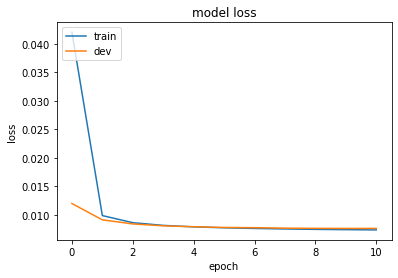

In [15]:
# Model training
# load training data
l=1500 # number of training and validation data
ftrain_Aug = np.load(f'Aug_1500_train.npz')
# load validation data
fval = np.load(f'1500_validation.npz')
# Data transformation
tr_Aug = tf.cast(ftrain_Aug['traindata'].T, dtype=tf.float32)
trl_Aug = tf.cast(ftrain_Aug['trainlabels'].T, dtype=tf.float32)
va = tf.cast(fval['validadata'].T, dtype=tf.float32)
val = tf.cast(fval['validalabels'].T, dtype=tf.float32)
# Creat model
AEPNET = create_AEPNET()
AEPNET.compile(optimizer=optim, loss=AEPNET_loss, metrics=AEPNET_res)
AEPNET_callbacks = [
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001, patience=3),
    AEPNET_tb]
# Model training
AEPNET_story = AEPNET.fit(x=tr_Aug, y=trl_Aug, 
                 batch_size=b_size, epochs=n_epochs, 
                 validation_data=(va, val), shuffle=True, callbacks=AEPNET_callbacks, verbose=0).history
# Model saving
AEPNET.save(f'Trained_models/AEPNET_Aug_{l:.0f}_train&valida_241119')

# Visualizing model training process

print(f'Total training and validation data number:{l:.0f}')
print(f'Training data number:{l*0.8:.0f}')
print(f'Validation data number:{l*0.2:.0f}')     
plt.plot(AEPNET_story['loss'])
plt.plot(AEPNET_story['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

## Load and deploy AE-PNet

In [17]:
## The path and model name can be cu
# AEPNET = keras.models.load_model('Trained_models/AEPNET_Aug_1500_train&valida_241119', 
#                                            custom_objects={'AEPNET_res': 'AEPNET_res', 'AEPNET_loss': 'AEPNET_loss'})

In [18]:
ftest = np.load('10000_test.npz')
#ftest_NoAug.files
te = tf.cast(ftest['testdata'].T, dtype=tf.float32)
# Deploy AE-PNet
AEPNET_pred = AEPNET.predict(te)

313/313 [==============================] - 3s 7ms/step


## Visualize prediction

In [19]:
# Waveform to be picked by AE-PNet
dfX_test = pd.DataFrame(ftest['testdata'])
# Manually picked P-wave arrival
dfy_test = pd.DataFrame(ftest['testlabels'])
# P-wave arrival picked by AE-PNet
df_AEPNET_pred = pd.DataFrame(AEPNET_pred[:,:,0].T)

(0.0, 0.5)

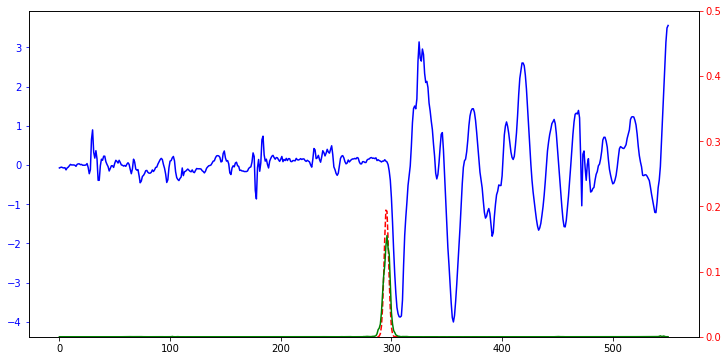

In [20]:
import random
N=dfX_test.shape[1]
random_int=random.randint(0,N-1)
hmm=random_int
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dfX_test.iloc[:, hmm], 'b')
ax.tick_params(axis='y', colors='b', which='both')
ax2 = ax.twinx()
ax2.plot(dfy_test.iloc[:, hmm], 'r--')
ax2.plot(sigmoid(df_AEPNET_pred.iloc[:,hmm]), 'g')
ax2.tick_params(axis='y', colors='r', which='both')
ax2.set_ylim(0, 0.5)